# Question 2.1

In [1]:
import json
import pprint
import pandas as pd
import csv
import os
import math
import matplotlib.pyplot as plt
import seaborn as sns

In [18]:
def q2_1():
    years = [2015, 2016, 2017, 2018]

    columns = ['eventIdx', 'game_id', 'Distance from Net', 'Angle from Net', 'Is Goal', 'Is Net Empty']
    
    data = []
    
    def get_distance_angle(shoot_left, x_coor, y_coor):
        if shoot_left == True:
            distance = math.sqrt((89 + x_coor) ** 2 + (y_coor) ** 2)
            if x_coor == -89:
                if y_coor > 0:
                    angle = 0
                elif y_coor < 0:
                    angle = 180
                elif y_coor == 0:
                    angle = 90
            else:
                if y_coor > 0:
                    angle = math.degrees(math.atan((89 + x_coor) / y_coor))
                elif y_coor < 0:
                    angle = 180 - abs(math.degrees(math.atan((89 + x_coor) / y_coor)))
                elif y_coor == 0:
                    angle = 90
                    
        elif shoot_left == False:
            distance = math.sqrt((89 - x_coor) ** 2 + (y_coor) ** 2)
            if x_coor == 89:
                if y_coor > 0:
                    angle = 180
                elif y_coor < 0:
                    angle = 0
                elif y_coor == 0:
                    angle = 90
            else:
                if y_coor > 0:
                    angle = 180 - abs(math.degrees(math.atan((89 - x_coor) / y_coor)))
                elif y_coor < 0:
                    angle = abs(math.degrees(math.atan((89 - x_coor) / y_coor)))
                elif y_coor == 0:
                    angle = 90
                
        return distance, angle
    
    for year in years:
        for file in os.listdir(f'../../m2_JSON_data/regular_season/{year}'):
            if file[-5:] == '.json':
                # Opening JSON file
                f = open(f'../../m2_JSON_data/regular_season/{year}/{file}')

                game_id = int(file[:-5])

                loaded_json = json.load(f)

                all_plays = loaded_json['liveData']['plays']['allPlays']

                home_team = loaded_json['gameData']['teams']['home'].get('name')

                home_side = 'NA'
                if len(loaded_json['liveData']['linescore']['periods']) > 0:
                    home_side = loaded_json['liveData']['linescore']['periods'][0]['home'].get('rinkSide')
                    
                for i in range(len(all_plays)):
                    event = all_plays[i]['result']['event']
                    if event == 'Shot' or event == 'Goal':

                        period = all_plays[i]['about']['period']

                        team_name = all_plays[i]['team']['name']

                        if home_team == team_name:
                            home_or_away = 'Home'
                        else:
                            home_or_away = 'Away'
                        
                        eventIdx = all_plays[i]['about']['eventIdx']
                            
                        x_coor = 'NA'
                        y_coor = 'NA'
                        if 'coordinates' in all_plays[i]:
                            x_coor = all_plays[i]['coordinates'].get('x')
                            y_coor = all_plays[i]['coordinates'].get('y')
                    
                        x_coor = int(float(x_coor)) if bool(x_coor) and x_coor != 'NA' else False
                        y_coor = int(float(y_coor)) if bool(y_coor) and y_coor != 'NA' else False
                        
                        

                        if x_coor and y_coor:
                            if home_side == 'right':                    
                                if home_or_away == 'Home':
                                    if int(period) % 2 == 1:
                                        # shoot left
                                        distance, angle = get_distance_angle(True, x_coor, y_coor)

                                    elif int(period) % 2 == 0:
                                        # shoot right
                                        distance, angle = get_distance_angle(False, x_coor, y_coor)
                                else:
                                    if int(period) % 2 == 1:
                                        # shoot right
                                        distance, angle = get_distance_angle(False, x_coor, y_coor)

                                    elif int(period) % 2 == 0:
                                        # shoot left
                                        distance, angle = get_distance_angle(True, x_coor, y_coor)

                            elif home_side == 'left':
                                if home_or_away == 'Home':
                                    if int(period) % 2 == 1:
                                        # shoot right
                                        distance, angle = get_distance_angle(False, x_coor, y_coor)

                                    elif int(period) % 2 == 0:
                                        # shoot left
                                        distance, angle = get_distance_angle(True, x_coor, y_coor)
                                        
                                else:
                                    if int(period) % 2 == 1:
                                        # shoot left
                                        distance, angle = get_distance_angle(True, x_coor, y_coor)

                                    elif int(period) % 2 == 0:
                                        # shoot right
                                        distance, angle = get_distance_angle(False, x_coor, y_coor)
                            
                        is_net_empty = False
                        if event == 'Goal':
                            if 'emptyNet' in all_plays[i]['result']:
                                is_net_empty = all_plays[i]['result']['emptyNet']

                        row_data = [eventIdx, game_id, distance, angle, int(event == 'Goal'), int(is_net_empty)]

                        data.append(row_data)

    # create file path if it doesn't exist
    filename = f'../../m2_CSV_data/all_data.csv'
    dirname = os.path.dirname(filename)
    if not os.path.exists(dirname):
        os.makedirs(dirname)

    # writing to csv file 
    with open(filename, 'w+') as csvfile: 
        # creating a csv writer object 
        csvwriter = csv.writer(csvfile) 

        # writing the fields 
        csvwriter.writerow(columns) 

        # writing the data rows 
        csvwriter.writerows(data)

In [19]:
q2_1()

# Question 2.1: Shot Counts Histogram, binned by distance

In [4]:
def q2_1_1():
    shot_distances = []
    goal_distances = []
                        
    # csv_path = f'../../m2_CSV_data/all_data.csv'
    csv_path = '/Users/xiaoxinzhou/Documents/IFT6758_M2_CSV_data/all_data.csv'
    with open(csv_path) as csvfile:
        data = csv.DictReader(csvfile)

        for row in data:
            is_goal = int(row.get('Is Goal'))
            if is_goal == 1:
                goal_distances.append(float(row.get('Distance from Net')))
            elif is_goal == 0:
                shot_distances.append(float(row.get('Distance from Net')))
    
                    
    manual_bins = [0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100, 
                   105, 110, 115, 120, 125, 130, 135, 140, 145, 150, 155, 160, 165, 170, 175, 180, 185, 
                   190]
    manual_bins_string = ['0-5', '5-10', '10-15', '15-20', '20-25', '25-30', '30-35', '35-40', '40-45', '45-50', '50-55',
             '55-60', '60-65', '65-70', '70-75', '75-80', '80-85', '85-90', '90-95', '95-100', '100-105', 
             '105-110', '110-115', '115-120', '120-125', '125-130', '130-135', '135-140', '140-145', 
             '145-150', '150-155', '155-160', '160-165', '165-170', '170-175', '175-180', '180-185', '185-190']
    
    (shot_counts, shot_bins, patches) = plt.hist(shot_distances, bins=manual_bins)
    print(shot_counts)
    print(shot_bins)
    (goal_counts, goal_bins, patches) = plt.hist(goal_distances, bins=shot_bins)
    print(goal_counts)
    plt.close()
    
    plt.figure(figsize=(45, 28))
    plt.bar(manual_bins_string, shot_counts)
    plt.bar(manual_bins_string, goal_counts, bottom=shot_counts)
    plt.xlabel("Shot Distance (feet)", fontsize=20)
    plt.ylabel("Shot or Goal Count", fontsize=20)
    plt.legend(["Shots", "Goals"],loc=2,prop={'size': 16})
    plt.title(f"Shot or Goal Counts based on Shot Distance in the 2015-2018 Season", fontsize=20)
    
    plt.rc('xtick', labelsize=16)
    plt.rc('ytick', labelsize=16)
    
    plt.show()
    plt.close()

[  568. 21236. 30124. 20903. 19861. 21678. 22904. 24108. 22990. 20032.
 21027. 21173. 11636.  3822.  1829.  1650.  1439.  1418.   949.   484.
   377.   398.   277.   171.   535.   898.   767.   694.   838.   862.
   898.   928.  1012.  1232.  1269.   461.   396.    75.]
[  0   5  10  15  20  25  30  35  40  45  50  55  60  65  70  75  80  85
  90  95 100 105 110 115 120 125 130 135 140 145 150 155 160 165 170 175
 180 185 190]
[ 253. 4961. 5997. 3579. 2783. 2465. 2044. 1578. 1132.  839.  804.  724.
  382.  113.   70.   60.   57.   47.   64.   38.   30.   16.   23.   23.
   39.   51.   57.   40.   45.   70.   85.   94.  118.  193.  217.   42.
   39.   15.]


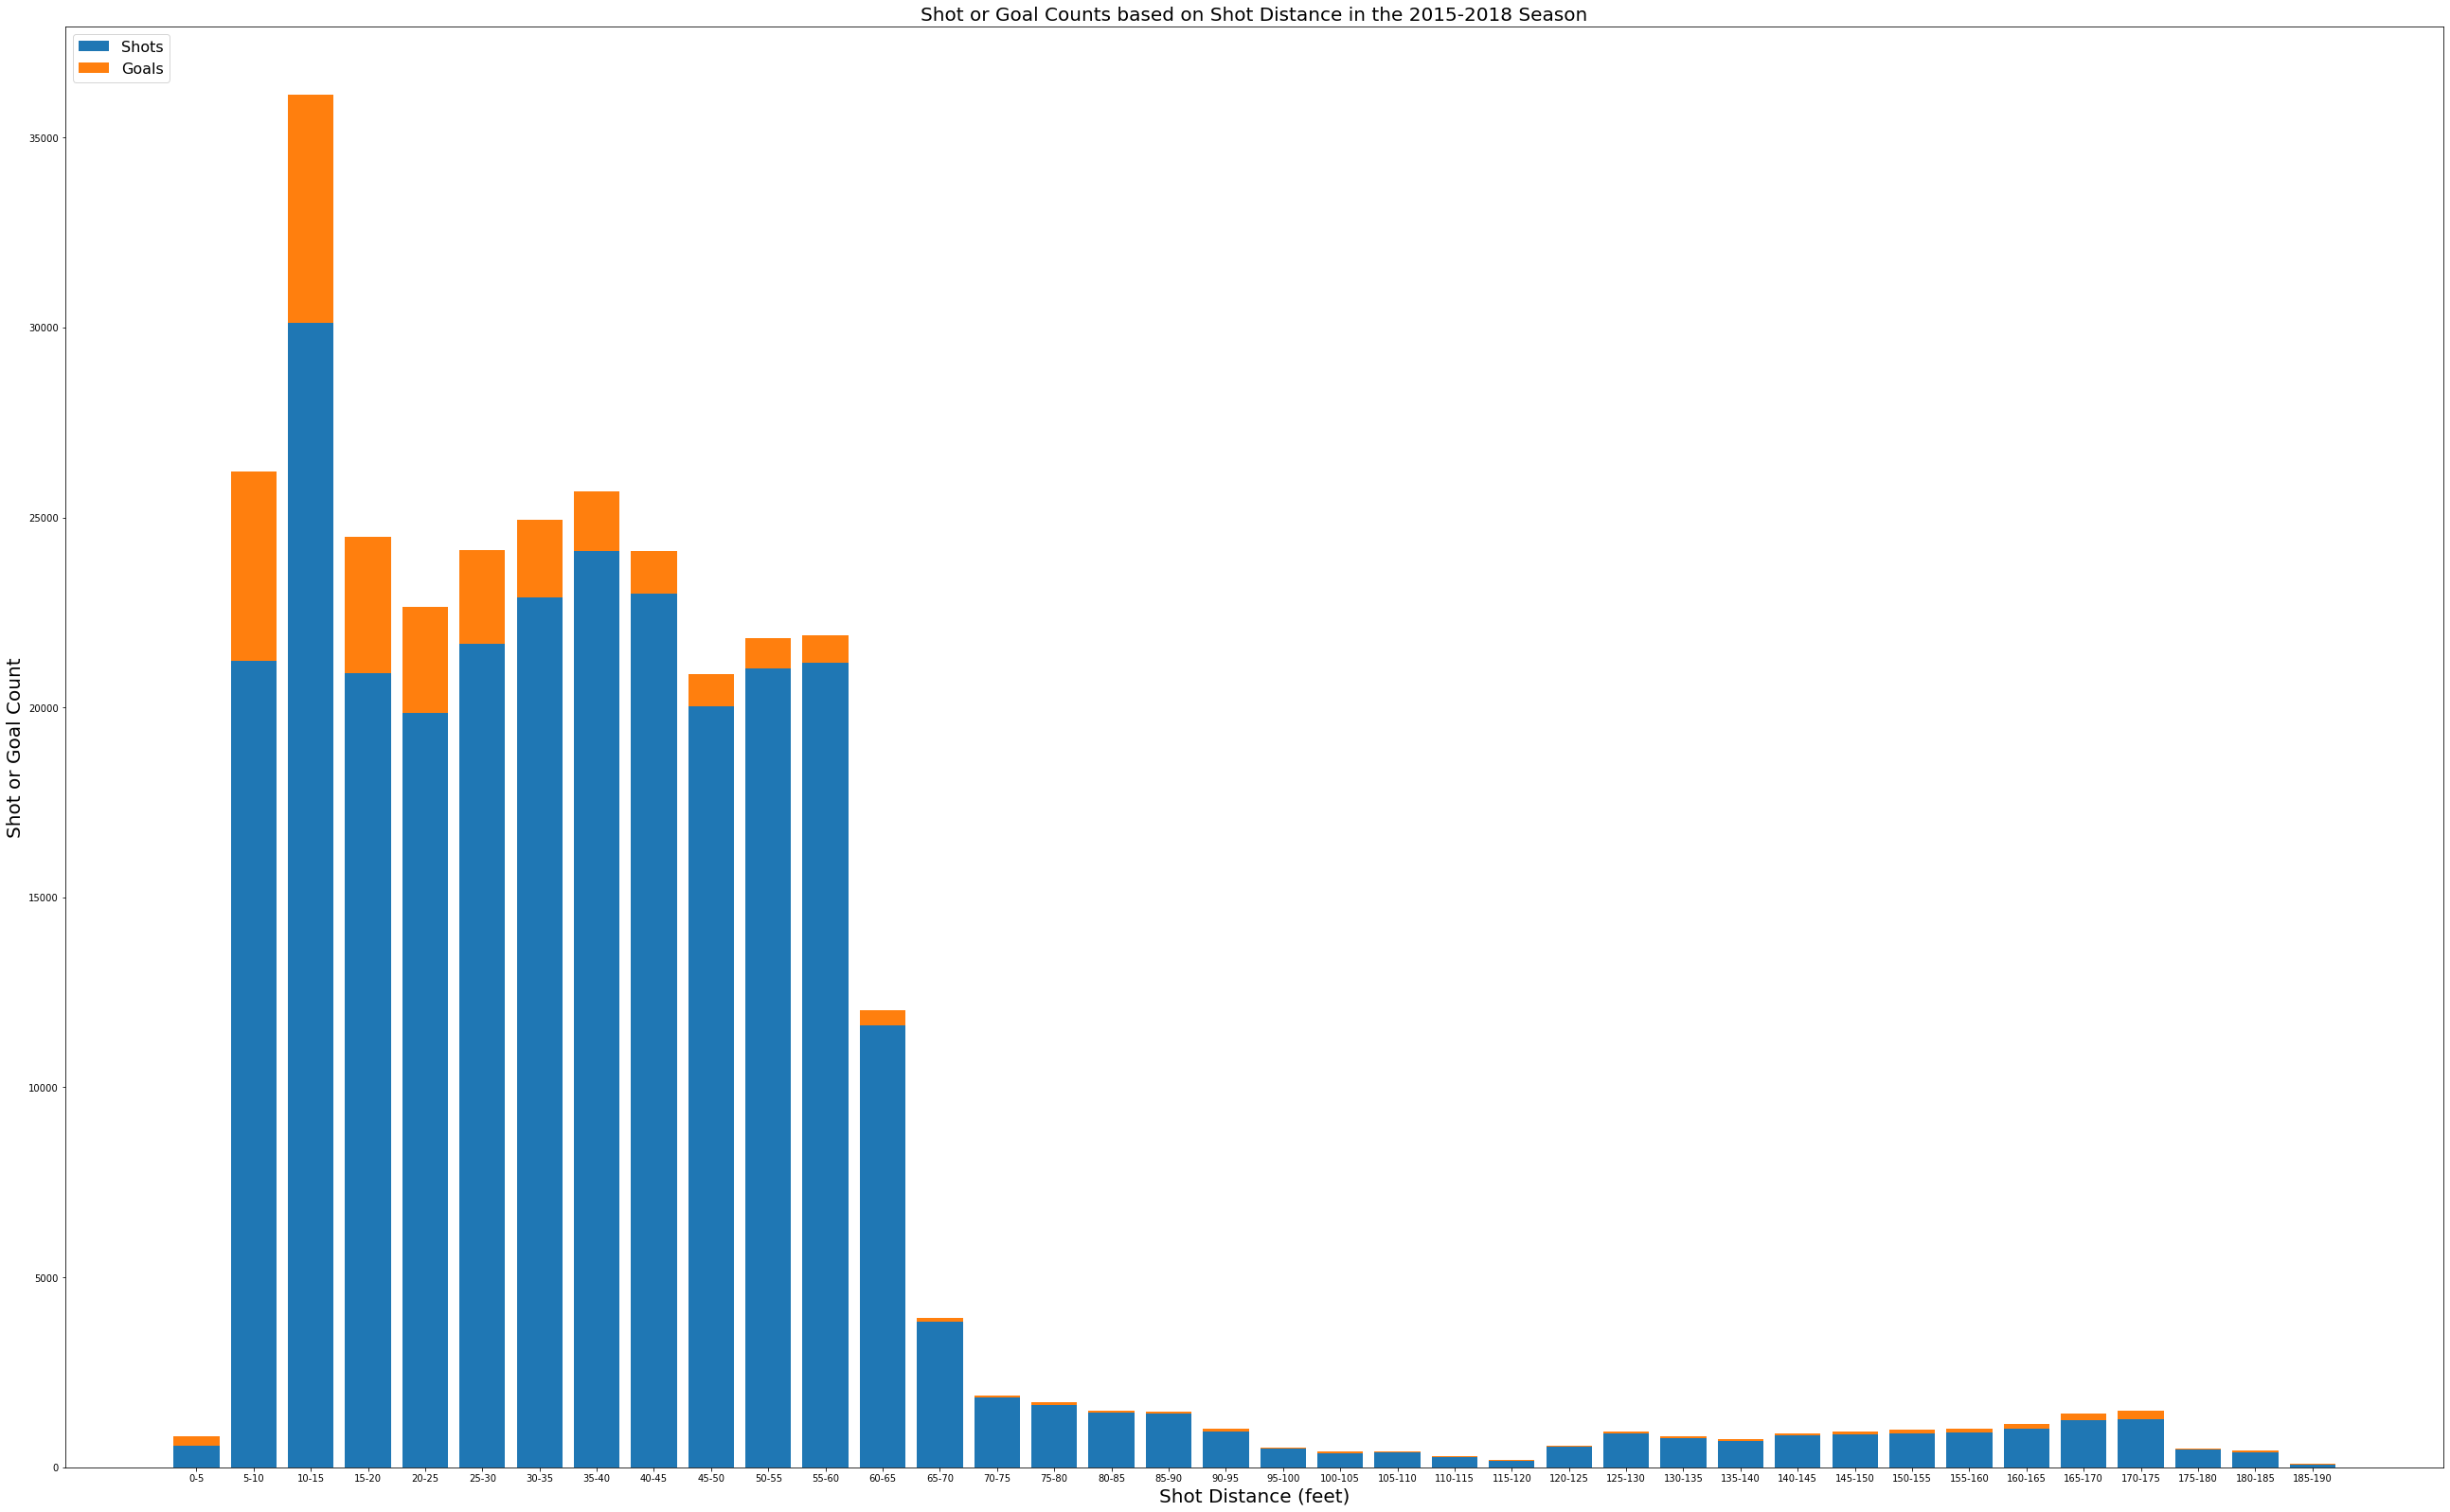

In [5]:
q2_1_1()

# Question 2.1: Shot Counts Histogram, binned by angle

In [6]:
def q2_1_2():
    shot_angles = []
    goal_angles = []
                        
    csv_path = f'../../m2_CSV_data/all_data.csv'
    with open(csv_path) as csvfile:
        data = csv.DictReader(csvfile)

        for row in data:
            is_goal = int(row.get('Is Goal'))
            if is_goal == 1:
                goal_angles.append(float(row.get('Angle from Net')))
            elif is_goal == 0:
                shot_angles.append(float(row.get('Angle from Net')))
    
    manual_bins = [0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100, 
                   105, 110, 115, 120, 125, 130, 135, 140, 145, 150, 155, 160, 165, 170, 175, 180]
    
    manual_bins_string = ['0-5', '5-10', '10-15', '15-20', '20-25', '25-30', '30-35', '35-40', '40-45', '45-50', '50-55',
             '55-60', '60-65', '65-70', '70-75', '75-80', '80-85', '85-90', '90-95', '95-100', '100-105', 
             '105-110', '110-115', '115-120', '120-125', '125-130', '130-135', '135-140', '140-145', 
             '145-150', '150-155', '155-160', '160-165', '165-170', '170-175', '175-180']
    
    (shot_counts, shot_bins, patches) = plt.hist(shot_angles, bins=manual_bins)
    print(shot_counts)
    print(shot_bins)
    (goal_counts, goal_bins, patches) = plt.hist(goal_angles, bins=shot_bins)
    print(goal_counts)
    plt.close()
    
    plt.figure(figsize=(45, 8))
    plt.bar(manual_bins_string, shot_counts)
    plt.bar(manual_bins_string, goal_counts, bottom=shot_counts)
    plt.xlabel("Shot Angle (degrees)")
    plt.ylabel("Shot or Goal Count")
    plt.legend(["Shots", "Goals"])
    plt.title(f"Shot or Goal Counts based on Shot Angle in the 2015-2018 Season")
    plt.show()
    plt.close()

[  863.  1635.  2156.  2847.  3374.  4220.  5046.  6196.  6005. 10440.
 10484. 14144. 15506. 13379. 10980. 10709. 11991. 11937. 12084. 12000.
 10933. 11270. 13515. 15958. 14768. 10382.  7234.  8289.  5582.  4510.
  3631.  2952.  2513.  1864.  1557.   771.]
[  0   5  10  15  20  25  30  35  40  45  50  55  60  65  70  75  80  85
  90  95 100 105 110 115 120 125 130 135 140 145 150 155 160 165 170 175
 180]
[  63.   91.  150.  200.  239.  338.  446.  577.  486. 1055. 1069. 1286.
 1370. 1316. 1328. 1419. 1695. 1582. 1670. 1774. 1473. 1344. 1375. 1403.
 1198. 1005.  579.  863.  472.  393.  297.  195.  162.  110.   86.   34.]


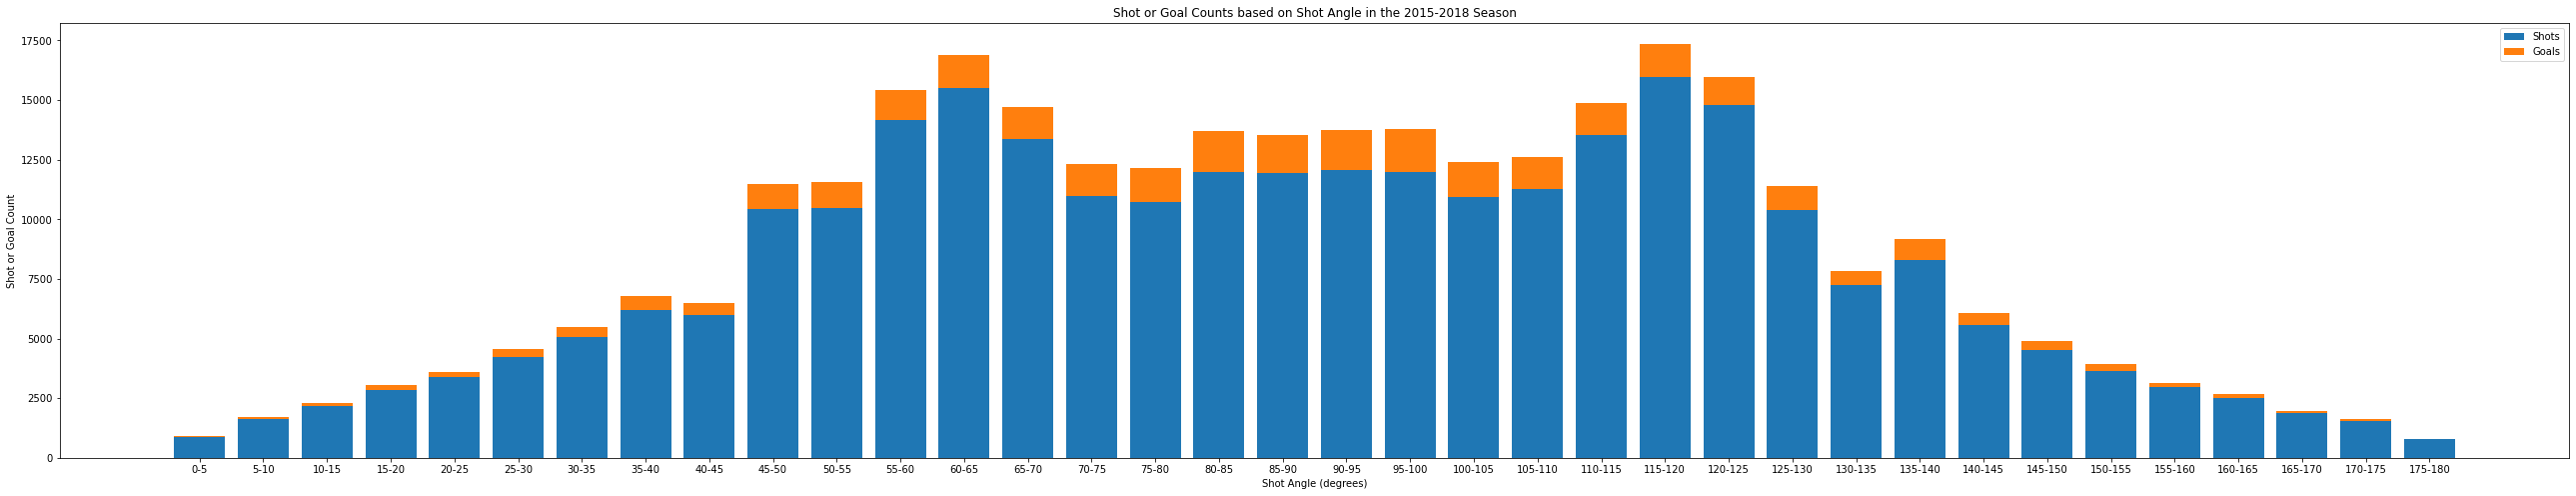

In [7]:
q2_1_2()

# Question 2.1: 2D Histogram

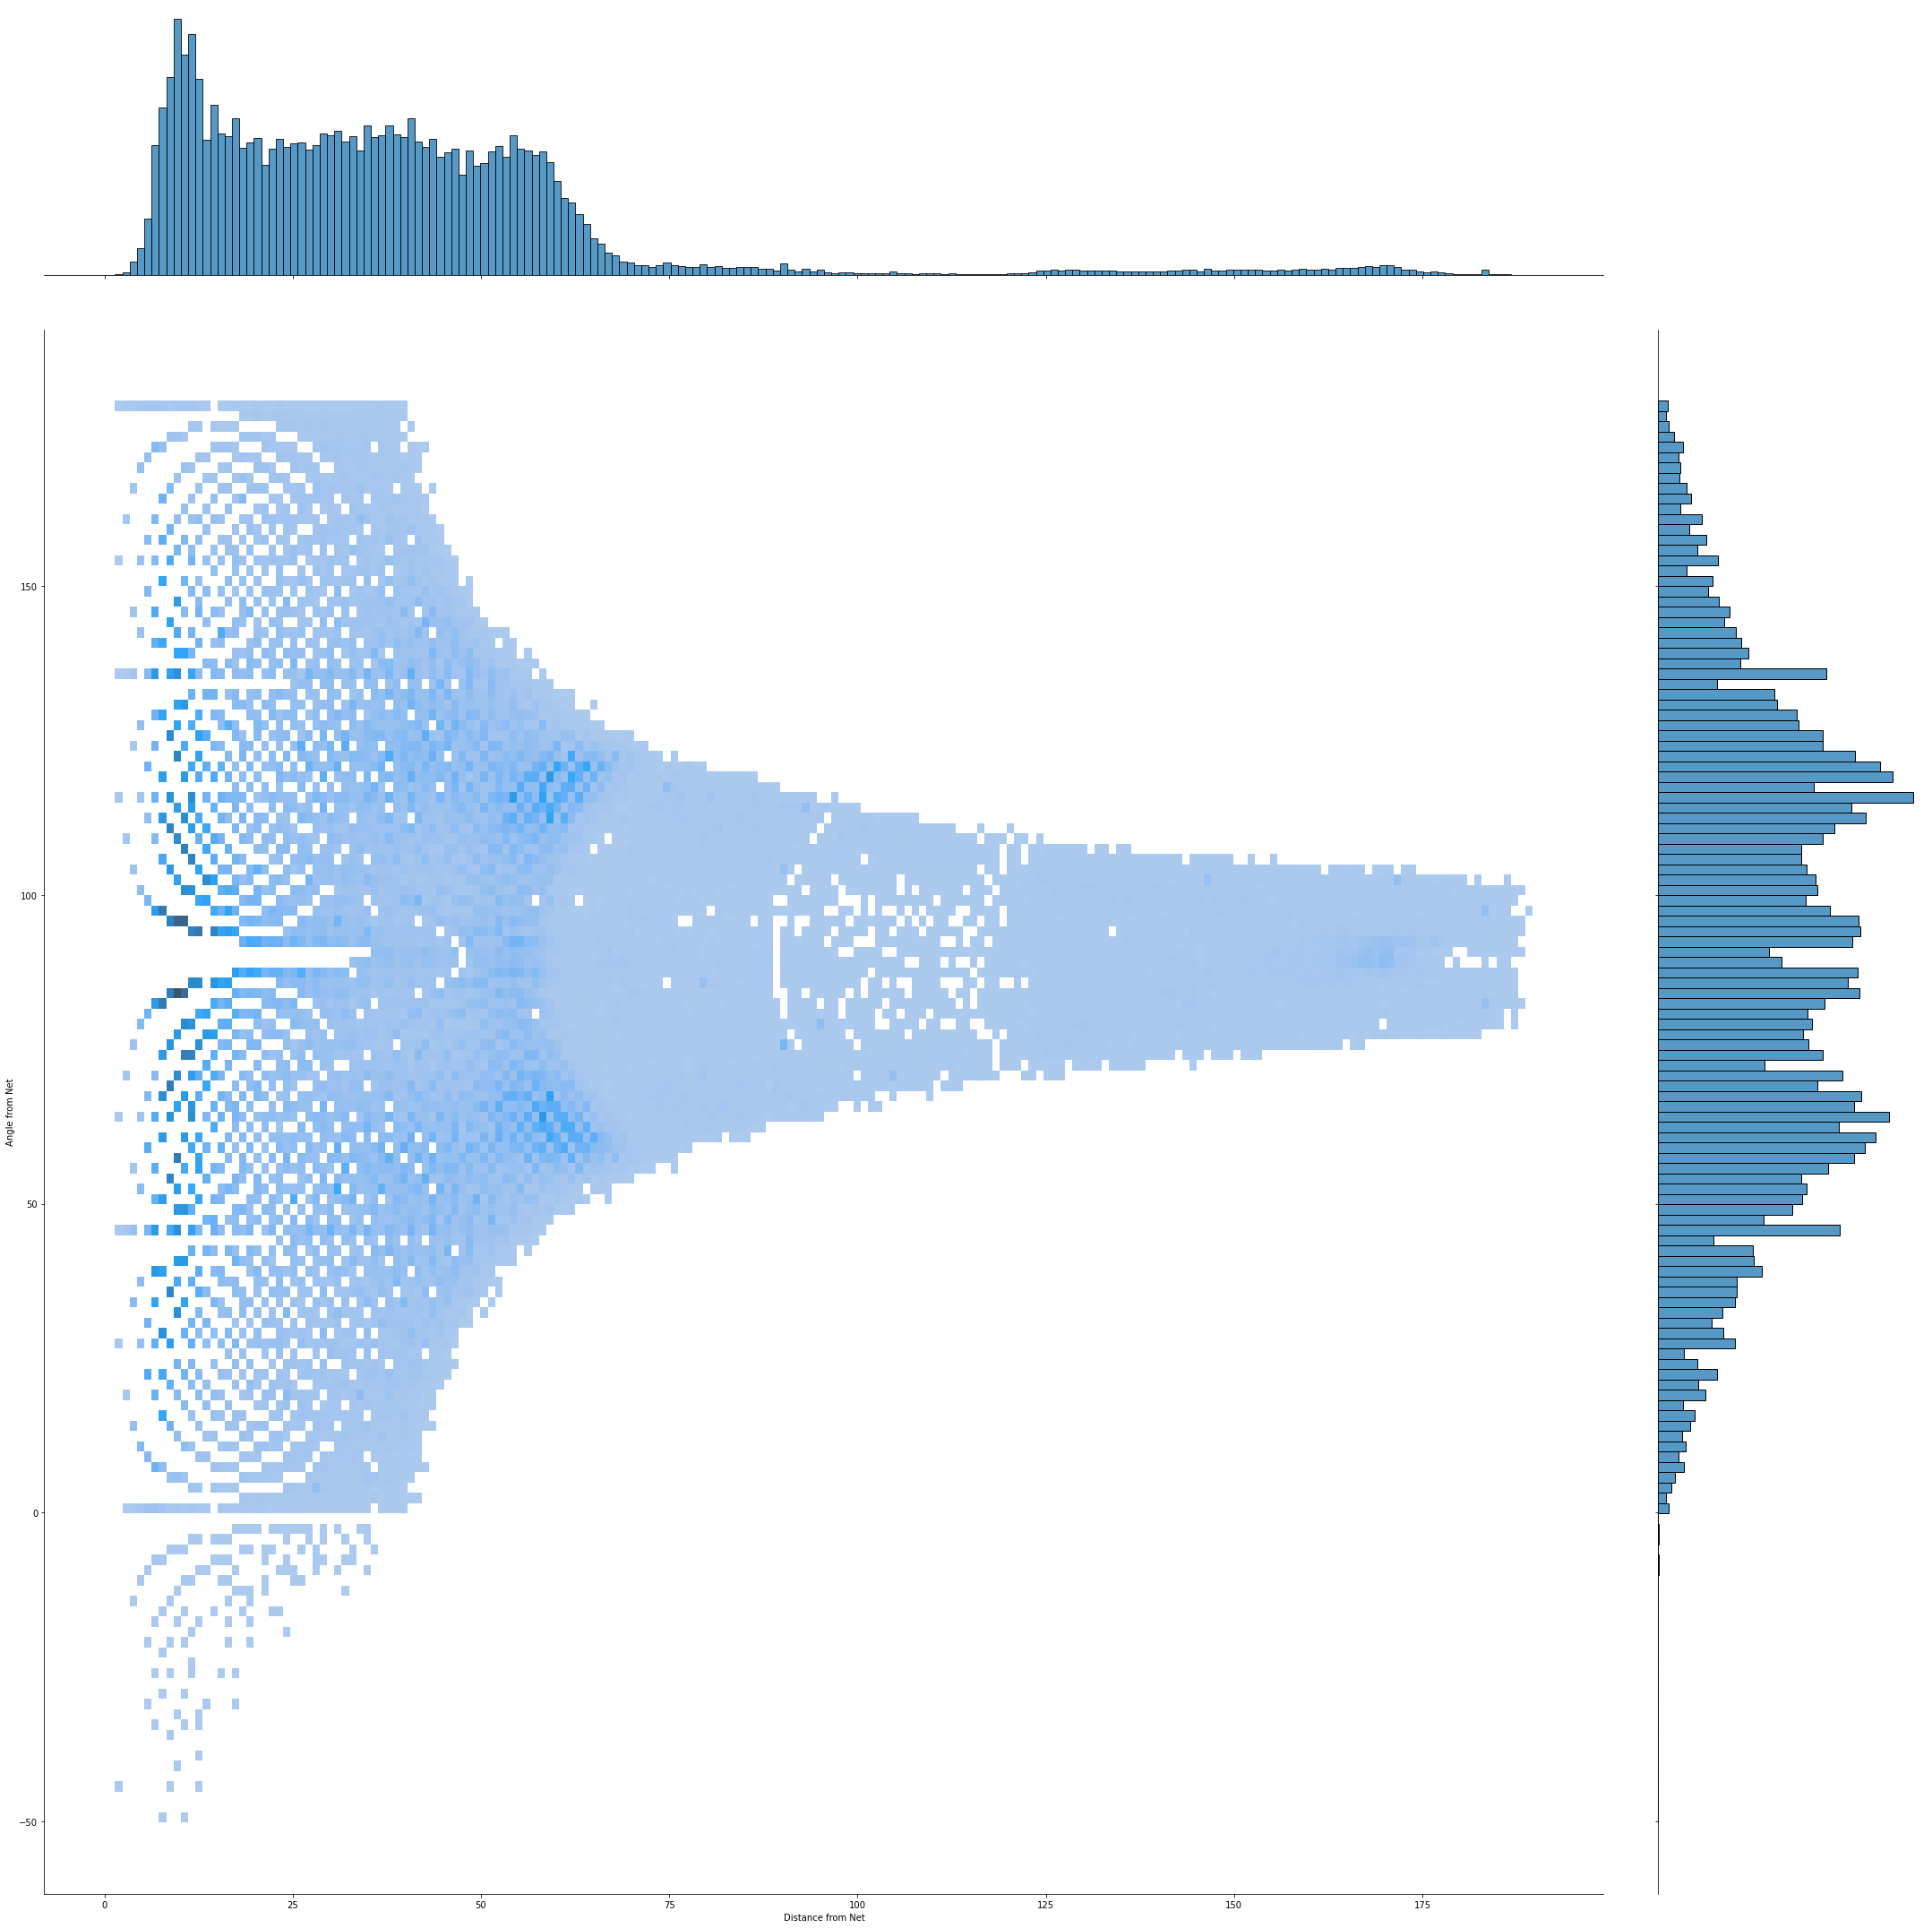

In [5]:
# penguins = sns.load_dataset("penguins")
# print(type(penguins))
# print(penguins)
# sns.jointplot(data=penguins, x="bill_length_mm", y="bill_depth_mm")

# https://github.com/mwaskom/seaborn/issues/469

# csv_path = f'../../m2_CSV_data/all_data.csv'
csv_path = '/Users/xiaoxinzhou/Documents/IFT6758_M2_CSV_data/all_data.csv'
all_data = pd.read_csv(csv_path)

sns.jointplot(data=all_data, x="Distance from Net", y="Angle from Net", kind='hist', height=30)
# sns.jointplot(data=all_data,
#                      kind='hist', 
#                      height=30)

# plot.axes.set_title("Histogram of shot counts",fontsize=20)
# plot.set_xlabel("Distance from Net",fontsize=20)
# plot.set_ylabel("Angle from Net",fontsize=20)
# plot.tick_params(labelsize=16)
plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=16)

# Question 2.2: Goal Rate to Distance

In [10]:
def q2_2_1():
    shot_distances = []
    goal_distances = []
                        
    csv_path = f'../../m2_CSV_data/all_data.csv'
    with open(csv_path) as csvfile:
        data = csv.DictReader(csvfile)

        for row in data:
            is_goal = int(row.get('Is Goal'))
            if is_goal == 1:
                goal_distances.append(float(row.get('Distance from Net')))
            elif is_goal == 0:
                shot_distances.append(float(row.get('Distance from Net')))
                    
    manual_bins = [0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100, 
                   105, 110, 115, 120, 125, 130, 135, 140, 145, 150, 155, 160, 165, 170, 175, 180, 185, 
                   190]
    
    manual_bins_string = ['0-5', '5-10', '10-15', '15-20', '20-25', '25-30', '30-35', '35-40', '40-45', '45-50', '50-55',
             '55-60', '60-65', '65-70', '70-75', '75-80', '80-85', '85-90', '90-95', '95-100', '100-105', 
             '105-110', '110-115', '115-120', '120-125', '125-130', '130-135', '135-140', '140-145', 
             '145-150', '150-155', '155-160', '160-165', '165-170', '170-175', '175-180', '180-185', '185-190']
    
    (shot_counts, shot_bins, patches) = plt.hist(shot_distances, bins=manual_bins)
    print(shot_counts)
    print(shot_bins)
    (goal_counts, goal_bins, patches) = plt.hist(goal_distances, bins=shot_bins)
    print(goal_counts)
    plt.close()
    
    goal_chance = goal_counts / (goal_counts + shot_counts)
    print(goal_chance)
    
    plt.figure(figsize=(45, 8))
    # plt.bar(manual_bins_string, goal_chance)
    plt.plot(manual_bins_string, goal_chance)
    plt.xlabel("Shot Distance (feet)")
    plt.ylabel("Goal Percentage")
    plt.title(f"Goal Percentage based on Shot Distance in the 2015-2018 Season")
    plt.show()

[  568. 21236. 30124. 20903. 19861. 21678. 22904. 24108. 22990. 20032.
 21027. 21173. 11636.  3822.  1829.  1650.  1439.  1418.   949.   484.
   377.   398.   277.   171.   535.   898.   767.   694.   838.   862.
   898.   928.  1012.  1232.  1269.   461.   396.    75.]
[  0   5  10  15  20  25  30  35  40  45  50  55  60  65  70  75  80  85
  90  95 100 105 110 115 120 125 130 135 140 145 150 155 160 165 170 175
 180 185 190]
[ 253. 4961. 5997. 3579. 2783. 2465. 2044. 1578. 1132.  839.  804.  724.
  382.  113.   70.   60.   57.   47.   64.   38.   30.   16.   23.   23.
   39.   51.   57.   40.   45.   70.   85.   94.  118.  193.  217.   42.
   39.   15.]
[0.30816078 0.18937283 0.1660253  0.14618904 0.12290231 0.10209999
 0.08193042 0.06143424 0.04692812 0.04019932 0.03682836 0.03306389
 0.03178565 0.02871665 0.03686151 0.03508772 0.0381016  0.03208191
 0.06317868 0.07279693 0.07371007 0.03864734 0.07666667 0.1185567
 0.06794425 0.05374078 0.06917476 0.05449591 0.05096263 0.0751073
 0.

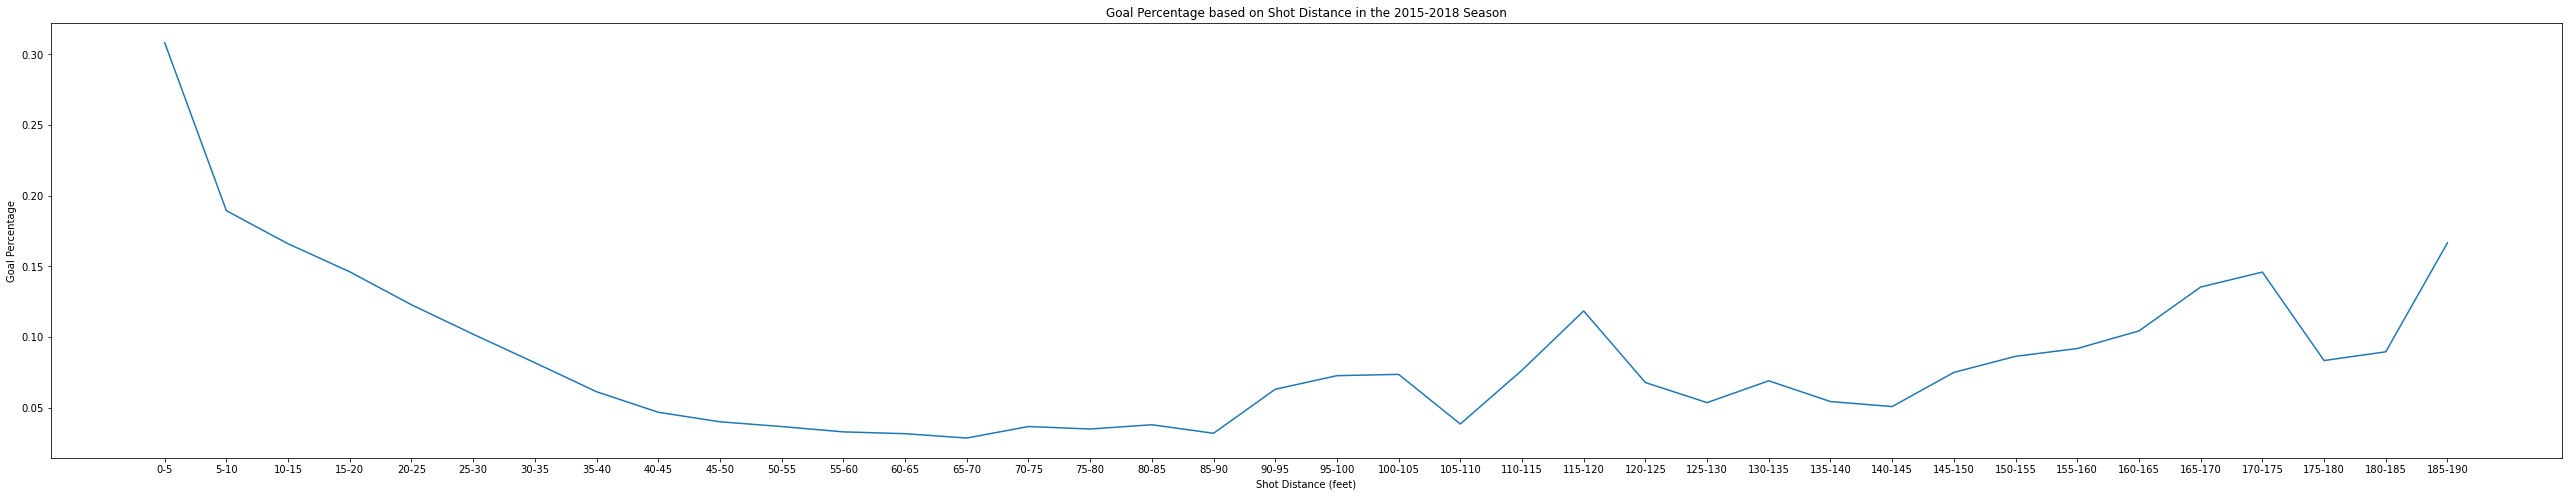

In [11]:
q2_2_1()

# Question 2.2: Goal Rate to Angle

In [12]:
def q2_2_2():
    shot_angles = []
    goal_angles = []
                        
    csv_path = f'../../m2_CSV_data/all_data.csv'
    with open(csv_path) as csvfile:
        data = csv.DictReader(csvfile)

        for row in data:
            is_goal = int(row.get('Is Goal'))
            if is_goal == 1:
                goal_angles.append(float(row.get('Angle from Net')))
            elif is_goal == 0:
                shot_angles.append(float(row.get('Angle from Net')))
    
    manual_bins = [0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100, 
                   105, 110, 115, 120, 125, 130, 135, 140, 145, 150, 155, 160, 165, 170, 175, 180]
    
    manual_bins_string = ['0-5', '5-10', '10-15', '15-20', '20-25', '25-30', '30-35', '35-40', '40-45', '45-50', '50-55', 
                          '55-60', '60-65', '65-70', '70-75', '75-80', '80-85', '85-90', '90-95', '95-100', '100-105', 
                          '105-110', '110-115', '115-120', '120-125', '125-130', '130-135', '135-140', '140-145', 
                          '145-150', '150-155', '155-160', '160-165', '165-170', '170-175', '175-180']
    
    (shot_counts, shot_bins, patches) = plt.hist(shot_angles, bins=manual_bins)
    print(shot_counts)
    print(shot_bins)
    (goal_counts, goal_bins, patches) = plt.hist(goal_angles, bins=shot_bins)
    print(goal_counts)
    plt.close()
    
    goal_chance = goal_counts / (goal_counts + shot_counts)
    print(goal_chance)
    
    plt.figure(figsize=(45, 8))
    # plt.bar(manual_bins_string, goal_chance)
    plt.plot(manual_bins_string, goal_chance)
    plt.xlabel("Shot Angle (degrees)")
    plt.ylabel("Goal Percentage")
    plt.title(f"Goal Percentage based on Shot Angle in the 2015-2018 Season")
    plt.show()

[  863.  1635.  2156.  2847.  3374.  4220.  5046.  6196.  6005. 10440.
 10484. 14144. 15506. 13379. 10980. 10709. 11991. 11937. 12084. 12000.
 10933. 11270. 13515. 15958. 14768. 10382.  7234.  8289.  5582.  4510.
  3631.  2952.  2513.  1864.  1557.   771.]
[  0   5  10  15  20  25  30  35  40  45  50  55  60  65  70  75  80  85
  90  95 100 105 110 115 120 125 130 135 140 145 150 155 160 165 170 175
 180]
[  63.   91.  150.  200.  239.  338.  446.  577.  486. 1055. 1069. 1286.
 1370. 1316. 1328. 1419. 1695. 1582. 1670. 1774. 1473. 1344. 1375. 1403.
 1198. 1005.  579.  863.  472.  393.  297.  195.  162.  110.   86.   34.]
[0.06803456 0.05272306 0.0650477  0.06563833 0.06615001 0.07415533
 0.08120903 0.0851912  0.0748729  0.09177903 0.09253008 0.08334413
 0.08118037 0.08955427 0.1078973  0.11700198 0.12384919 0.11702049
 0.12141922 0.12879338 0.11873287 0.10654828 0.09234385 0.08081332
 0.07503445 0.08825854 0.07410726 0.09429633 0.07796498 0.08015501
 0.075611   0.06196378 0.06056075 0.

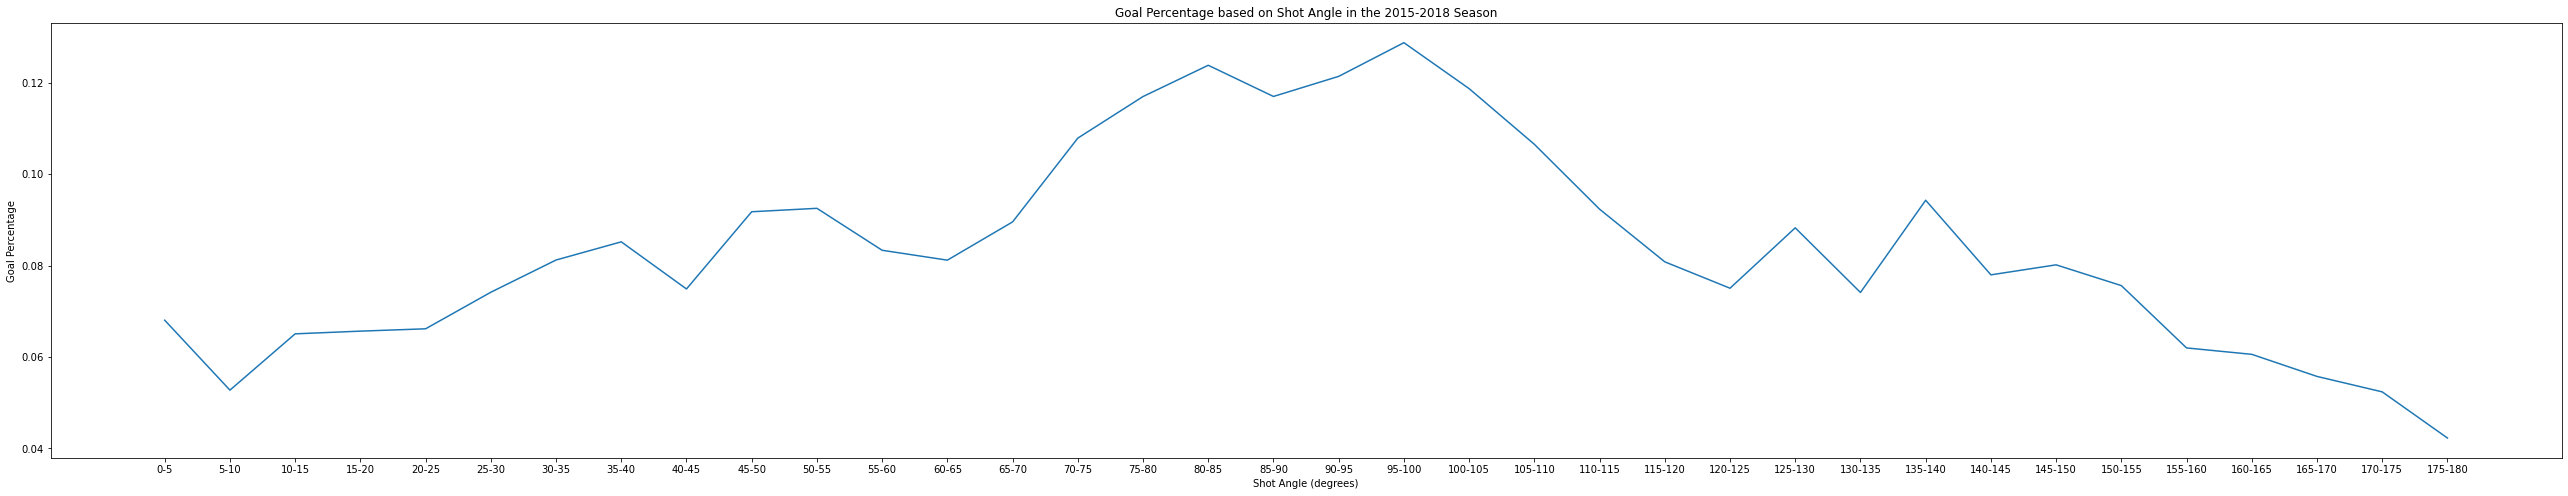

In [13]:
q2_2_2()

# Question 2.3

In [20]:
def q2_3():
    empty_net = []
    non_empty_net = []
                    
    csv_path = f'../../m2_CSV_data/all_data.csv'
    with open(csv_path) as csvfile:
        data = csv.DictReader(csvfile)

        for row in data:
            if int(row.get('Is Goal')) == 1:
                if int(row.get('Is Net Empty')) == 1:
                    empty_net.append(float(row.get('Distance from Net')))
                else:
                    non_empty_net.append(float(row.get('Distance from Net')))
                    
    manual_bins = [0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100, 
                   105, 110, 115, 120, 125, 130, 135, 140, 145, 150, 155, 160, 165, 170, 175, 180, 185, 
                   190]
    
    manual_bins_string = ['0-5', '5-10', '10-15', '15-20', '20-25', '25-30', '30-35', '35-40', '40-45', '45-50', '50-55',
             '55-60', '60-65', '65-70', '70-75', '75-80', '80-85', '85-90', '90-95', '95-100', '100-105', 
             '105-110', '110-115', '115-120', '120-125', '125-130', '130-135', '135-140', '140-145', 
             '145-150', '150-155', '155-160', '160-165', '165-170', '170-175', '175-180', '180-185', '185-190']
    
    (empty_net_counts, goal_bins, patches) = plt.hist(empty_net, bins=manual_bins)
    print(empty_net_counts)
    print(goal_bins)
    (non_empty_net_counts, goal_bins, patches) = plt.hist(non_empty_net, bins=goal_bins)
    print(non_empty_net_counts)
    plt.close()
    
    plt.figure(figsize=(45, 8))

    plt.bar(manual_bins_string, non_empty_net_counts)
    plt.bar(manual_bins_string, empty_net_counts, bottom=non_empty_net_counts)
    plt.xlabel("Goal Distance (feet)")
    plt.ylabel("Empty or Non-empty Net Count")
    plt.legend(["Non-empty Net", "Empty Net"])
    plt.title(f"Empty or Non-empty Net Counts based on Shot Distance in the 2015-2018 Season")
    plt.show()
    plt.close()

[ 9. 61. 98. 76. 72. 69. 50. 70. 67. 61. 53. 47. 45. 46. 49. 44. 48. 30.
 44. 29. 25. 11. 19. 15. 24. 16. 29. 21. 21. 20. 25. 17. 24. 17. 17. 10.
 22. 13.]
[  0   5  10  15  20  25  30  35  40  45  50  55  60  65  70  75  80  85
  90  95 100 105 110 115 120 125 130 135 140 145 150 155 160 165 170 175
 180 185 190]
[2.440e+02 4.900e+03 5.899e+03 3.503e+03 2.711e+03 2.396e+03 1.994e+03
 1.508e+03 1.065e+03 7.780e+02 7.510e+02 6.770e+02 3.370e+02 6.700e+01
 2.100e+01 1.600e+01 9.000e+00 1.700e+01 2.000e+01 9.000e+00 5.000e+00
 5.000e+00 4.000e+00 8.000e+00 1.500e+01 3.500e+01 2.800e+01 1.900e+01
 2.400e+01 5.000e+01 6.000e+01 7.700e+01 9.400e+01 1.760e+02 2.000e+02
 3.200e+01 1.700e+01 2.000e+00]


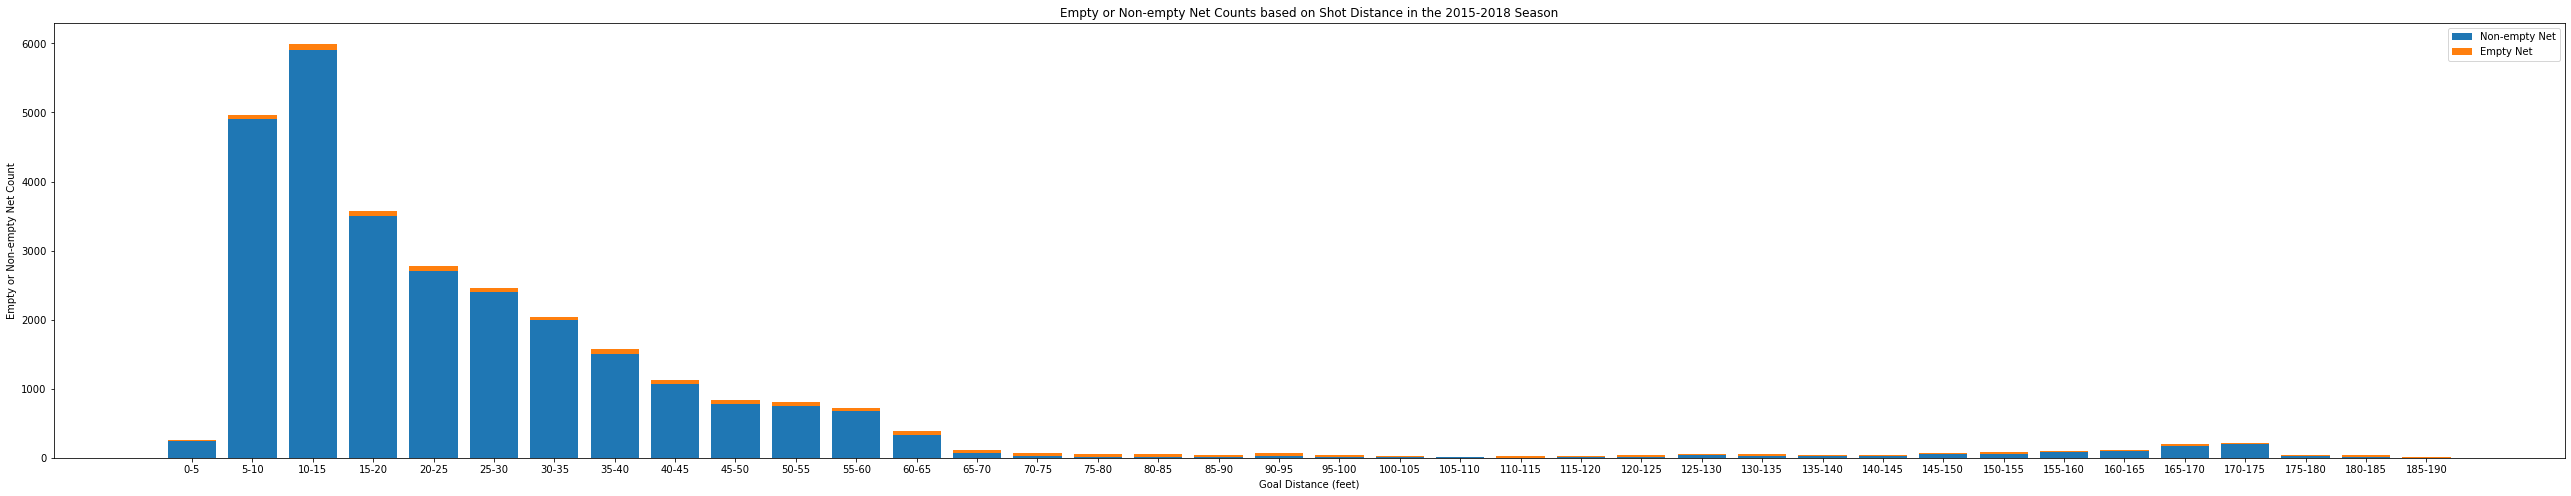

In [21]:
q2_3()